# Getting Started
 - Shows collision detection
 - Provides a plotting function
 - Creates a slightly optimized submission

In [36]:
import shapely
print(f'Using shapely {shapely.__version__}')

Using shapely 2.1.2


In [37]:
import math
import os
import random
from decimal import Decimal, getcontext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

pd.set_option('display.float_format', '{:.12f}'.format)

# Set precision for Decimal
getcontext().prec = 25
scale_factor = Decimal('1e15')

In [38]:
# Build the index of the submission, in the format:
#  <trees_in_problem>_<tree_index>

index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]

In [39]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

In [40]:
from decimal import Decimal

def generate_grid(width, height):
    """
    Generate a grid of (x, y, degree) tuples using Decimal for precision.

    Args:
        width: Number of columns
        height: Number of rows

    Returns:
        List of lists, where each inner list is a row containing (x, y, degree) tuples
    """
    grid = []

    for row in range(height):
        row_data = []
        for col in range(width):
            x = Decimal(col) * Decimal('0.7')
            y = Decimal(row) * Decimal('1.0')
            degree = Decimal('0')
            row_data.append((x, y, degree))
        grid.append(row_data)

    return grid

def generate_odd_grid(width, height):
    """
    Generate an 'odd' grid of (x, y, degree) tuples using Decimal for precision.
    Starting at x=0.35, y=0.8 with degree=180

    Args:
        width: Number of columns
        height: Number of rows

    Returns:
        List of lists, where each inner list is a row containing (x, y, degree) tuples
    """
    grid = []
    x_start = Decimal('0.35')
    y_start = Decimal('0.8')
    x_increment = Decimal('0.7')
    y_increment = Decimal('1.0')

    for row in range(height):
        row_data = []
        for col in range(width):
            x = x_start + (Decimal(col) * x_increment)
            y = y_start + (Decimal(row) * y_increment)
            degree = Decimal('180')
            row_data.append((x, y, degree))
        grid.append(row_data)

    return grid

In [41]:
# Print the coordinates of a grid as a table
import pandas as pd

def print_grid_table(grid, grid_name="Grid"):
    rows = []
    for row_idx, row in enumerate(grid):
        for col_idx, (x, y, deg) in enumerate(row):
            rows.append({
                "row": row_idx,
                "col": col_idx,
                "x": float(x),
                "y": float(y),
                "degree": float(deg)
            })
    df = pd.DataFrame(rows)
    print(f"{grid_name} coordinates:")
    print(df.to_string(index=False))

# Example usage:
grid_even = generate_grid(3, 2)
grid_odd = generate_odd_grid(2,1)
print_grid_table(grid_even, "Even Grid")
print_grid_table(grid_odd, "Odd Grid")


Even Grid coordinates:
 row  col              x              y         degree
   0    0 0.000000000000 0.000000000000 0.000000000000
   0    1 0.700000000000 0.000000000000 0.000000000000
   0    2 1.400000000000 0.000000000000 0.000000000000
   1    0 0.000000000000 1.000000000000 0.000000000000
   1    1 0.700000000000 1.000000000000 0.000000000000
   1    2 1.400000000000 1.000000000000 0.000000000000
Odd Grid coordinates:
 row  col              x              y           degree
   0    0 0.350000000000 0.800000000000 180.000000000000
   0    1 1.050000000000 0.800000000000 180.000000000000


In [42]:
# Flexible plotting for experimenting with grid settings
import matplotlib.pyplot as plt
from decimal import Decimal

def plot_grid_trees(grid, tree_kwargs=None, title=None):
    """
    Plot a grid of ChristmasTree objects with optional per-tree settings.
    tree_kwargs: dict or function(row, col, x, y, deg) -> dict
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    for row_idx, row in enumerate(grid):
        for col_idx, (x, y, deg) in enumerate(row):
            kwargs = {}
            if callable(tree_kwargs):
                kwargs = tree_kwargs(row_idx, col_idx, x, y, deg)
            elif isinstance(tree_kwargs, dict):
                kwargs = tree_kwargs
            tree = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(deg), **kwargs)
            poly = tree.polygon
            x_poly, y_poly = poly.exterior.xy
            x_plot = [float(Decimal(val) / scale_factor) for val in x_poly]
            y_plot = [float(Decimal(val) / scale_factor) for val in y_poly]
            ax.fill(x_plot, y_plot, color='forestgreen', alpha=0.5)
            ax.plot(x_plot, y_plot, color='darkgreen', linewidth=1)
            ax.text(float(x), float(y), f"({row_idx},{col_idx})", color='red', fontsize=8, ha='center')
    ax.set_aspect('equal')
    ax.autoscale()
    ax.axis('off')
    if title:
        plt.title(title)
    plt.show()


In [43]:
# Bounding box function for any custom grid

def get_bounding_box_from_grid(grid):
    """
    Given a grid (list of rows of (x, y, deg)), return the bounding box (min_x, max_x, min_y, max_y)
    of all tree polygons in the grid.
    """
    from decimal import Decimal
    all_points = []
    for row in grid:
        for x, y, deg in row:
            tree = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(deg))
            poly = tree.polygon
            all_points.extend(poly.exterior.coords)
    x_vals = [float(Decimal(x) / scale_factor) for x, y in all_points]
    y_vals = [float(Decimal(y) / scale_factor) for x, y in all_points]
    min_x, max_x = min(x_vals), max(x_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    return min_x, max_x, min_y, max_y

# Example usage for your custom grids:
bbox_even = get_bounding_box_from_grid(custom_even_grid)
bbox_odd = get_bounding_box_from_grid(custom_odd_grid)
print("Custom Even Grid bounding box:", bbox_even)
print("Custom Odd Grid bounding box:", bbox_odd)


Custom Even Grid bounding box: (-0.35, 1.8, -0.2, 1.55)
Custom Odd Grid bounding box: (0.0, 1.4, 0.0, 1.0)


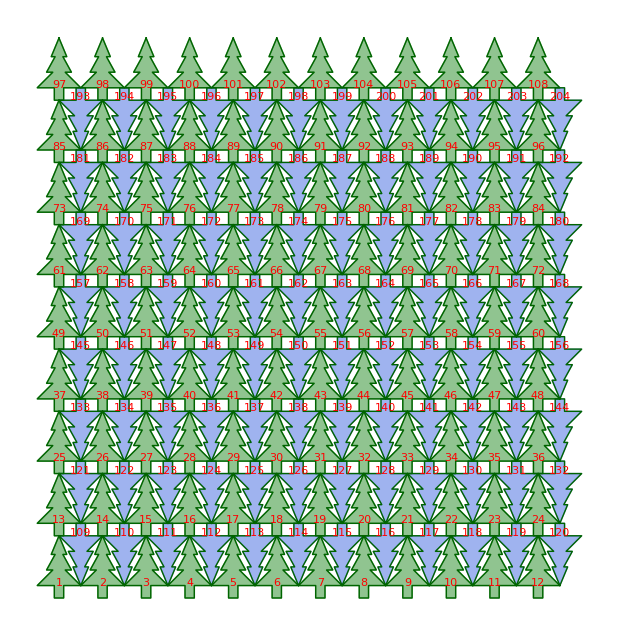

In [125]:
def plot_christmas_tree_objects(*grids):
    """
    Plot one or more grids of ChristmasTree objects using their polygons.
    Each grid is plotted in a different color for distinction.
    """
    import itertools
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = itertools.cycle(['forestgreen', 'royalblue', 'orange', 'purple', 'teal'])
    tree_num = 1
    for grid, color in zip(grids, colors):
        for row in grid:
            for x, y, deg in row:
                tree = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(deg))
                poly = tree.polygon
                x_poly, y_poly = poly.exterior.xy
                x_plot = [float(Decimal(val) / scale_factor) for val in x_poly]
                y_plot = [float(Decimal(val) / scale_factor) for val in y_poly]
                ax.fill(x_plot, y_plot, color=color, alpha=0.5)
                ax.plot(x_plot, y_plot, color='darkgreen', linewidth=1)
                ax.text(x, y, str(tree_num), color='red', fontsize=8, ha='center')
                tree_num += 1
    ax.set_aspect('equal')
    ax.autoscale()
    ax.axis('off')
    plt.show()

# Example usage:
grid_even = generate_grid(width=12, height=9)
grid_odd = generate_odd_grid(width=12, height =8)
plot_christmas_tree_objects(grid_even, grid_odd)



In [45]:
# Function to compute the bounding box (dimensions) of the charted image
def get_christmas_tree_chart_dimensions(even_width, even_height, odd_width=None, odd_height=None):
    """
    Returns the (min_x, max_x, min_y, max_y) of the plotted area for the given grid parameters.
    If odd_width/odd_height are not provided, only the even grid is considered.
    """
    from decimal import Decimal
    all_points = []
    # Even grid
    grid_even = generate_grid(width=even_width, height=even_height)
    for row in grid_even:
        for x, y, deg in row:
            tree = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(deg))
            poly = tree.polygon
            all_points.extend(poly.exterior.coords)
    # Odd grid (optional)
    if odd_width is not None and odd_height is not None:
        grid_odd = generate_odd_grid(width=odd_width, height=odd_height)
        for row in grid_odd:
            for x, y, deg in row:
                tree = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(deg))
                poly = tree.polygon
                all_points.extend(poly.exterior.coords)
    # Convert to float and scale
    x_vals = [float(Decimal(x) / scale_factor) for x, y in all_points]
    y_vals = [float(Decimal(y) / scale_factor) for x, y in all_points]
    min_x, max_x = min(x_vals), max(x_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    return min_x, max_x, min_y, max_y


In [46]:
# Example: Compute bounding box from actual coordinates in grid_even and grid_odd

def get_bounding_box_from_grids(*grids):
    """
    Given one or more grids (as lists of (x, y, deg)), return the bounding box (min_x, max_x, min_y, max_y)
    of all tree polygons in all grids.
    """
    from decimal import Decimal
    all_points = []
    for grid in grids:
        for row in grid:
            for x, y, deg in row:
                tree = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(deg))
                poly = tree.polygon
                all_points.extend(poly.exterior.coords)
    x_vals = [float(Decimal(x) / scale_factor) for x, y in all_points]
    y_vals = [float(Decimal(y) / scale_factor) for x, y in all_points]
    min_x, max_x = min(x_vals), max(x_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    return min_x, max_x, min_y, max_y

# Usage example:
grid_even = generate_grid(width=1, height=1)
grid_odd = generate_odd_grid(width=1, height=1)
bbox = get_bounding_box_from_grids(grid_even, grid_odd)
print("Bounding box from actual grid coordinates:", bbox)


Bounding box from actual grid coordinates: (-0.35, 0.7, -0.2, 1.0)


In [47]:
# Print only the width and height for grid_even (2,2) and grid_odd (2,1)
grid_even_test = generate_grid(width=1, height=1)
grid_odd_test = generate_odd_grid(width=1, height=2)
bbox_test = get_bounding_box_from_grids(grid_even_test, grid_odd_test)
width = bbox_test[1] - bbox_test[0]
height = bbox_test[3] - bbox_test[2]
print("Width:", width)
print("Height:", height)

Width: 1.0499999999999998
Height: 2.2


In [49]:
# Print the bounding box and area (score) for the combined custom grids
bbox = get_bounding_box_from_grid(custom_even_grid + custom_odd_grid)
width = bbox[1] - bbox[0]
height = bbox[3] - bbox[2]
area = width * height
print("Bounding box (min_x, max_x, min_y, max_y):", bbox)
print(f"Width: {width}, Height: {height}, Bounding Score (Area): {area}")


Bounding box (min_x, max_x, min_y, max_y): (-0.35, 1.8, -0.2, 1.55)
Width: 2.15, Height: 1.75, Bounding Score (Area): 3.7624999999999997


# This  Find optimal at Each Step 

In [123]:
# Stepwise bounding box score algorithm

def stepwise_bounding_scores(start=(12,8,12,8)):
    """
    For a given (even_w, even_h, odd_w, odd_h),
    try all single increments and rank by max(width, height).
    Returns a sorted list of (params, width, height, max_dim).
    """
    results = []
    for i in range(4):
        params = list(start)
        params[i] += 1
        grid_even = generate_grid(params[0], params[1])
        grid_odd = generate_odd_grid(params[2], params[3])
        bbox = get_bounding_box_from_grids(grid_even, grid_odd)
        width = bbox[1] - bbox[0]
        height = bbox[3] - bbox[2]
        max_dim = max(width, height)
        results.append((tuple(params), width, height, max_dim))
    # Sort by max_dim ascending
    results.sort(key=lambda x: x[3])
    print(f"Start: even=({start[0]},{start[1]}), odd=({start[2]},{start[3]})")
    for params, width, height, max_dim in results:
        print(f"Params: even=({params[0]},{params[1]}), odd=({params[2]},{params[3]}) | Width: {width:.3f}, Height: {height:.3f}, Max: {max_dim:.3f}")
    return results

# Example usage:
stepwise_bounding_scores((1,1,0,0))


Start: even=(1,1), odd=(0,0)
Params: even=(1,1), odd=(1,0) | Width: 0.700, Height: 1.000, Max: 1.000
Params: even=(1,1), odd=(0,1) | Width: 0.700, Height: 1.000, Max: 1.000
Params: even=(2,1), odd=(0,0) | Width: 1.400, Height: 1.000, Max: 1.400
Params: even=(1,2), odd=(0,0) | Width: 0.700, Height: 2.000, Max: 2.000


[((1, 1, 1, 0), 0.7, 1.0, 1.0),
 ((1, 1, 0, 1), 0.7, 1.0, 1.0),
 ((2, 1, 0, 0), 1.4, 1.0, 1.4),
 ((1, 2, 0, 0), 0.7, 2.0, 2.0)]

In [62]:
# Iterative stepwise bounding box minimization loop

def iterative_stepwise_minimization(start=(13,8,12,8), iterations=10):
    """
    Repeatedly applies stepwise_bounding_scores, each time using the best (lowest max_dim) result as the new input.
    Returns a table of the lowest value (params, width, height, max_dim) for each loop.
    """
    history = []
    current = start
    for loop in range(1, iterations+1):
        results = stepwise_bounding_scores(current)
        best = results[0]  # lowest max_dim (sorted)
        params, width, height, max_dim = best
        history.append({
            'loop': loop,
            'params': params,
            'width': width,
            'height': height,
            'max_dim': max_dim
        })
        current = params  # Use best as next input
    # Output as a table
    import pandas as pd
    df = pd.DataFrame(history)
    print(df[['loop','params','width','height','max_dim']])
    return df

# Example usage:
iterative_stepwise_minimization((1,1,1,1), iterations=40)


Start: even=(1,1), odd=(1,1)
Params: even=(2,1), odd=(1,1) | Width: 1.400, Height: 1.200, Max: 1.400
Params: even=(1,1), odd=(2,1) | Width: 1.750, Height: 1.200, Max: 1.750
Params: even=(1,2), odd=(1,1) | Width: 1.050, Height: 2.000, Max: 2.000
Params: even=(1,1), odd=(1,2) | Width: 1.050, Height: 2.200, Max: 2.200
Start: even=(2,1), odd=(1,1)
Params: even=(2,1), odd=(2,1) | Width: 1.750, Height: 1.200, Max: 1.750
Params: even=(2,2), odd=(1,1) | Width: 1.400, Height: 2.000, Max: 2.000
Params: even=(3,1), odd=(1,1) | Width: 2.100, Height: 1.200, Max: 2.100
Params: even=(2,1), odd=(1,2) | Width: 1.400, Height: 2.200, Max: 2.200
Start: even=(2,1), odd=(2,1)
Params: even=(2,2), odd=(2,1) | Width: 1.750, Height: 2.000, Max: 2.000
Params: even=(3,1), odd=(2,1) | Width: 2.100, Height: 1.200, Max: 2.100
Params: even=(2,1), odd=(2,2) | Width: 1.750, Height: 2.200, Max: 2.200
Params: even=(2,1), odd=(3,1) | Width: 2.450, Height: 1.200, Max: 2.450
Start: even=(2,2), odd=(2,1)
Params: even=(3,2), 

,loop,params,width,height,max_dim
0,1,"(2, 1, 1, 1)",1.400000000000,1.200000000000,1.400000000000
1,2,"(2, 1, 2, 1)",1.750000000000,1.200000000000,1.750000000000
2,3,"(2, 2, 2, 1)",1.750000000000,2.000000000000,2.000000000000
3,4,"(3, 2, 2, 1)",2.100000000000,2.000000000000,2.100000000000
4,5,"(3, 2, 2, 2)",2.100000000000,2.200000000000,2.200000000000
5,6,"(3, 2, 3, 2)",2.450000000000,2.200000000000,2.450000000000
6,7,"(4, 2, 3, 2)",2.800000000000,2.200000000000,2.800000000000
7,8,"(4, 3, 3, 2)",2.800000000000,3.000000000000,3.000000000000
8,9,"(4, 3, 4, 2)",3.150000000000,3.000000000000,3.150000000000
9,10,"(4, 3, 4, 3)",3.150000000000,3.200000000000,3.200000000000


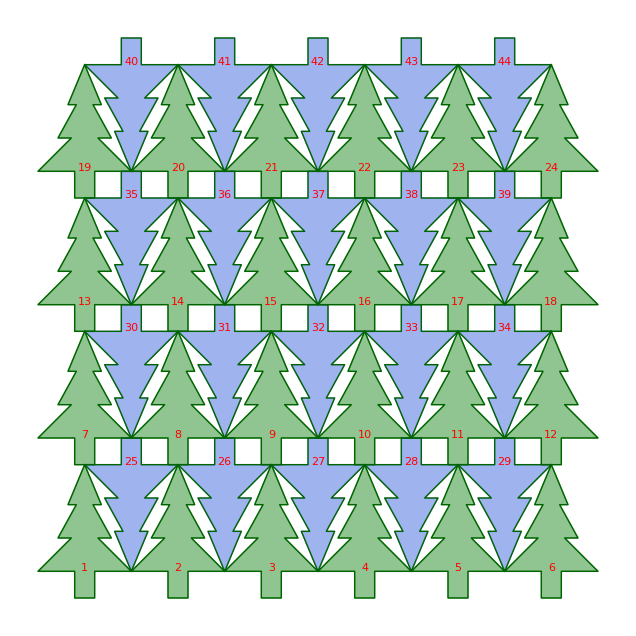

In [135]:
def plot_christmas_tree_objects(*grids):
    """
    Plot one or more grids of ChristmasTree objects using their polygons.
    Each grid is plotted in a different color for distinction.
    """
    import itertools
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = itertools.cycle(['forestgreen', 'royalblue', 'orange', 'purple', 'teal'])
    tree_num = 1
    for grid, color in zip(grids, colors):
        for row in grid:
            for x, y, deg in row:
                tree = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(deg))
                poly = tree.polygon
                x_poly, y_poly = poly.exterior.xy
                x_plot = [float(Decimal(val) / scale_factor) for val in x_poly]
                y_plot = [float(Decimal(val) / scale_factor) for val in y_poly]
                ax.fill(x_plot, y_plot, color=color, alpha=0.5)
                ax.plot(x_plot, y_plot, color='darkgreen', linewidth=1)
                ax.text(x, y, str(tree_num), color='red', fontsize=8, ha='center')
                tree_num += 1
    ax.set_aspect('equal')
    ax.autoscale()
    ax.axis('off')
    plt.show()

# Example usage:
grid_even = generate_grid(width=6, height=4)
grid_odd = generate_odd_grid(width=5, height =4)
plot_christmas_tree_objects(grid_even, grid_odd)


In [126]:
# Given a list of (even_w, even_h, odd_w, odd_h) tuples, print the (x, y, degree) for each tree in the grids

def print_grid_tree_coordinates(param_list):
    """
    For each (even_w, even_h, odd_w, odd_h) in param_list, print the (x, y, degree) for all trees in the even and odd grids.
    """
    from decimal import Decimal
    for idx, params in enumerate(param_list):
        even_w, even_h, odd_w, odd_h = params
        grid_even = generate_grid(even_w, even_h)
        grid_odd = generate_odd_grid(odd_w, odd_h)
        print(f"Step {idx+1}: even=({even_w},{even_h}), odd=({odd_w},{odd_h})")
        print("Even grid:")
        for row in grid_even:
            for x, y, deg in row:
                print(f"  (x={float(x):.3f}, y={float(y):.3f}, deg={float(deg):.1f})")
        print("Odd grid:")
        for row in grid_odd:
            for x, y, deg in row:
                print(f"  (x={float(x):.3f}, y={float(y):.3f}, deg={float(deg):.1f})")
        print("-")

# Example usage:
# param_list = [(1,1,0,0), (1,1,1,1), (2,1,1,1)]
# print_grid_tree_coordinates(param_list)


In [128]:
# Example: Print (x, y, degree) for each tree in the provided parameter list
param_list = [
    (1,1,0,0), (1,1,1,1), (2,1,1,1), (2,1,2,1), (2,2,2,1), (3,2,2,1), (3,2,2,2), (3,2,3,2),
    (4,2,3,2), (4,3,3,2), (4,3,4,2), (4,3,4,3), (5,3,4,3), (5,3,5,3), (5,4,5,3), (6,4,5,3),
    (6,4,5,4), (6,4,6,4), (7,4,6,4), (7,5,6,4), (7,5,6,5), (7,5,7,5), (8,5,7,5), (8,5,8,5),
    (8,6,8,5), (8,6,8,6), (9,6,8,6), (9,6,9,6), (10,6,9,6), (10,7,9,6), (10,7,9,7), (10,7,10,7),
    (11,7,10,7), (11,8,10,7), (11,8,11,7), (11,8,11,8), (12,8,11,8), (12,8,12,8), (12,9,12,8),

]
print_grid_tree_coordinates(param_list)


Step 1: even=(1,1), odd=(0,0)
Even grid:
  (x=0.000, y=0.000, deg=0.0)
Odd grid:
-
Step 2: even=(1,1), odd=(1,1)
Even grid:
  (x=0.000, y=0.000, deg=0.0)
Odd grid:
  (x=0.350, y=0.800, deg=180.0)
-
Step 3: even=(2,1), odd=(1,1)
Even grid:
  (x=0.000, y=0.000, deg=0.0)
  (x=0.700, y=0.000, deg=0.0)
Odd grid:
  (x=0.350, y=0.800, deg=180.0)
-
Step 4: even=(2,1), odd=(2,1)
Even grid:
  (x=0.000, y=0.000, deg=0.0)
  (x=0.700, y=0.000, deg=0.0)
Odd grid:
  (x=0.350, y=0.800, deg=180.0)
  (x=1.050, y=0.800, deg=180.0)
-
Step 5: even=(2,2), odd=(2,1)
Even grid:
  (x=0.000, y=0.000, deg=0.0)
  (x=0.700, y=0.000, deg=0.0)
  (x=0.000, y=1.000, deg=0.0)
  (x=0.700, y=1.000, deg=0.0)
Odd grid:
  (x=0.350, y=0.800, deg=180.0)
  (x=1.050, y=0.800, deg=180.0)
-
Step 6: even=(3,2), odd=(2,1)
Even grid:
  (x=0.000, y=0.000, deg=0.0)
  (x=0.700, y=0.000, deg=0.0)
  (x=1.400, y=0.000, deg=0.0)
  (x=0.000, y=1.000, deg=0.0)
  (x=0.700, y=1.000, deg=0.0)
  (x=1.400, y=1.000, deg=0.0)
Odd grid:
  (x=0.350, 